# **Mobile Robotics Project Report** 

**Group 36:** <br>
Vincent Gherold <br>
Vicente Carbon <br>
Yifei Luo <br>
Emeric de Galembert <br>

## **Introduction**

The following report will discuss the obtained results for the Basics of Mobile Robotics project. The objective of the project is to code a fully functional robot with the following specifics, a vision module to interpret and transcribe an environment for the robot to move in, and to continously track the position of the robot, a global navigation module to calculate the optimal path for the robot to reach its goal, a local navigation module to detect and avoid obstacles at any moment, a filtering unit that estimates the position of the robot depending on certain parameters, and lastly related to all of it is a control section to manage the movements and direction of the robot.

The entrance to a new tomb was recently discovered in the Valley of the Kings. Hundreds of Egyptologists have been trying to discover the secrets contained within the place but to no avail. What they don't know is that excavation Group 36 managed to get their hands on the map of the burried labyrinth. Unfortunately, the entrance to the sarcophagus room is too small for a human to fit. Furthermore, the old age of the structure leads to bricks falling from the roof which is quite dangerous for the explorers. The group thus decided to use a robot to further explore the insides and maybe discover the greatest Egyptian treasure yet.

### **Environment**

It was decided to implement the modules for a simple grid-type map. It is divided in 35 squares (5 rows and 7 columns), which can be white to represent a road or in black to represent a wall. The corners, the goal and the robot, are marked with special tags called ArUco markers. These choices make it possible for the camera and the vision module, to model a reproduction of the map and to accurately track the position and movements of the robot. The Thymio then has to follow the path given by the global navigation to reach the goal by staying on the roads, and during this it has to evade newly set obstacles using its sensors and the local navigator. Aside of the vision module, a Kalman filter was implemented to estimate the position of the robot with the x and y coordinates, the angle of the Thymio, and the velocities of the left and right motors. If the camera at some point loses its view of the robot, it has to continue on the path using the filter, until the vision is recovered or until it has reached the objective. The project is considered succesful if the robot reaches the goal-marker without any disturbance.

### **Structure**
We created a file called Manager that take care of calling all the others modules.

First, it handle the connection to the Thymio and then calibrate the camera (in order to have good color).

We compute the map and the path to the goal, start moving toward it little by little.

We have two differentes states:
- Global navigation: the robot move to the nearest checkpoint on the path. 
- Local navigation: the robot try to avoid the obstacle

As soon, we detect a obstacle, the manager switch to local navigation and when we finished the avoidance we come back the global.

If the robot is too far away from a checkpoint, the manager recompute the global navigation in order to find a path to the goal.

We mesured that we have a refresh rate of 5 actions per second for the global and local navigation

## **Modules**

All the parameters and constants for the project are stored in a config file ("config.yaml") in order to be able to edit and tune all the parameters quickly

### **Robot State estimation** 

The position and orientation of the robot are estimated by an extended Kalman filter. It allows to combine the position and angle measured from the camera and the robot's speed in order to have a robust and precise robot state estimation. This choice has been made because there are non linearities in the motion model (described below).

The camera is strongly accurate while the odometry (speed) sensors are less, but the prediction of that one is useful when the camera doesn’t succeed to detect the position of the robot. However, the odometry is effective only to detect a straight movement and not too much for a rotational movement.

For our project, the robot's position [x,y,theta] is required. We also choose to keep track of the motor speed [vr;vl] (vr for the speed right motor and vl for the speed left motor).



#### **Coordinate system**
The coordinate system is defined as follows:
<div style="text-align: center;"><img src="./images/coordinate_system.png" alt="Figure 1: Coordinate System" width="200"/></div>
The origin is at the top left corner of the map. All the values for x,y are in mm; vr, vl in mm/s and theta in rad.

#### **Discrete Model**
The discrete motion model for the Kalman filter is the following:
$$
\begin{array}{l}
z_{k+1}=f\left(z_{k}\right) 
\end{array}
$$
$$
\begin{array}{l}
z^{+}=\left(\begin{array}{l}
x \\
y \\
\theta \\
v_{r} \\
v_{l}
\end{array}\right)^{+}=\left(\begin{array}{l}
x+\frac{v_{r}+v_{l}}{2} \cos (\theta) T_{s} \\
y-\frac{v_{r}+v_{l}}{2} \sin (\theta) T_{s} \\
\theta+k_{s}\left(V_{r}-V_{l}\right) \\
v_{r} \\
v_{l}
\end{array}\right) + w
\end{array}
$$
Ks is a constant factor and Ts is the time between two iterations of the discrete model. w is the motion model with mean zero and covariance Q.
Because the theta positivity rotation is defined not in the right direction, we had to put a minus next to the sin;

#### **Measurement model**
The discrete measurement model is pretty simple:
$$
\begin{array}{l}
z_{k+1}=h\left(z_{k}\right) 
\end{array}
$$
$$
z^{+}=\left(\begin{array}{l}
x \\
y \\
\theta \\
v_{r} \\
v_{l}
\end{array}\right)^{+}=\left(\begin{array}{l}
x_{\text {mesured }} \\
y_{\text {mesured }} \\
\theta_{\text {mesured }} \\
v_{\text {r mesured }} \\
v_{\text {l mesured }}
\end{array}\right) + v
$$
where v is the measurement noise with covariance matrix R.
#### **Extended Kalman filter**
Here the algorithm behind the extended kalman filter
$$
\begin{aligned}
& \hat{\boldsymbol{x}}_{k \mid k-1}=f\left(\hat{\boldsymbol{x}}_{k-1 \mid k-1}, \boldsymbol{u}_k\right) \\
& \boldsymbol{P}_{k \mid k-1}=\boldsymbol{F}_k \boldsymbol{P}_{k-1 \mid k-1} \boldsymbol{F}_k^T+\boldsymbol{Q}_k \\
& \tilde{\boldsymbol{y}}_k=\boldsymbol{z}_k-h\left(\hat{\boldsymbol{x}}_{k \mid k-1}\right) \\
& \boldsymbol{S}_k=\boldsymbol{H}_k \boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_k^T+\boldsymbol{R}_k \\
& \boldsymbol{K}_k=\boldsymbol{P}_{k \mid k-1} \boldsymbol{H}_k^T \boldsymbol{S}_k^{-1} \\
& \hat{\boldsymbol{x}}_{k \mid k}=\hat{\boldsymbol{x}}_{k \mid k-1}+\boldsymbol{K}_k \tilde{\boldsymbol{y}}_k \\
& \boldsymbol{P}_{k \mid k}=\left(\boldsymbol{I}-\boldsymbol{K}_k \boldsymbol{H}_k\right) \boldsymbol{P}_{k \mid k-1}
\end{aligned}
$$

with ${\boldsymbol{x}}_{k} $ the state estimate and $\boldsymbol{P}_{k}$ the covariance estimate

$$
\begin{aligned}
& \boldsymbol{F}_k=\left.\frac{\partial f}{\partial \boldsymbol{x}}\right|_{\hat{\boldsymbol{x}}_{k-1 \mid k-1}, u_k} \\
& \boldsymbol{H}_k=\left.\frac{\partial h}{\partial \boldsymbol{x}}\right|_{\hat{\boldsymbol{x}}_{k \mid k-1}}
\end{aligned}
$$
where f is the motion model and h the measurement model; Q the motion noise and R the measurement 

There are two scenarios when measuring the states: <br>
The camera detects a position and angle:
We apply the full measurement model with speed position,angle <br>
The camera doesn’t detect anything:
We only use the motor speed to estimate the states.

#### **How do we estimate Ks and Ts?**
Between two iterations we mesure the time elasped between them. This is how the Ts estimation is done and Ts slighly change from iteration to another.

The estimation of Ks has been done by making the robot turning for about 50 sec and by counting the number of degres he has done. We obtained a coefficient of 9.20e-03



#### **Estimation of the noise matrices**
For the motion model:<br />
$$
Q=\begin{bmatrix}
0.04 &0 & 0 & 0& 0\\
& 0& 0.04& 0& 0 &0\\
& 0& 0& 0.02& 0& 0\\
& 0&0&0&6.153&0 \\
& 0&0&0&0&6.153
\end{bmatrix}
$$
We estimated 0.04, which is estimated arbitrarily, the same for the angle. For speed, we used our measurements from week 8, so half of the variance came from the motion and the other half from the measurement. <br>
For the measurement model:<br />
$$
R=
\begin{bmatrix}
1.798 & 0 & 0 & 0 & 0\\
0 & 1.798 & 0 & 0 & 0\\
0 & 0 & 0.002 & 0 & 0 \\
0 & 0 & 0 & 6.153 & 0 \\
0 & 0 & 0 & 0 & 6.153
\end{bmatrix}

$$
We placed the robot at a random position and angle on the map and then fetched 500 samples from the camera. By computing the variance, we obtain a value of 1.798 mm for the position and 0.002 for the angle. The speed estimation comes from week 8.

Here is a 3d plot of the position given from the extended kalman filter.
<div style="text-align: center;"><img src="./images/3d_plot.png" alt="Figure 2: 3d Plot" width="400"/></div>


Here is the code for the model and to compute the jacobian

    import math
    import numpy as np
    def motion_model(self,mean_state, Ts):
        (x,y,theta,vr,vl) = self.get_states(mean_state)
        return np.array([
            [x + (vr+vl)/2 * math.cos(theta)* Ts],
            [y - (vr+vl)/2 * math.sin(theta)* Ts],
            [theta + self.Ks * (vr - vl) * Ts],
            [vr],
            [vl],
        ])
    def compute_jacobian_motion(self, mean_state, Ts):
        (x,y,theta,vr,vl) = self.get_states(mean_state)
        return np.array([
                [1,0,(vr+vl)/2*(-math.sin(theta)*Ts),math.cos(theta)/2*Ts,math.cos(theta)/2*Ts],
                [0,1,(vr+vl)/2*(math.cos(theta)*Ts),math.sin(theta)/2*Ts,math.sin(theta)/2*Ts],
                [0,0,1,self.Ks * Ts,-self.Ks * Ts],
                [0,0,0,1,0],
                [0,0,0,0,1],
                ])
    def measurement_model(self, mean_state,camera_meas):
        (x,y,theta,vr,vl) = self.get_states(mean_state)
        if camera_meas:
            return np.array([
                [x],
                [y],
                [theta],
                [vr],
                [vl],
            ])
        else:
            return np.array([
                [vr],
                [vl],
            ])
    def compute_jacobian_measurement(self, mean_state,camera_meas, Ts):
        (x,y,theta,vr,vl) = self.get_states(mean_state)
        if camera_meas:
            return np.array([
                    [1,0,0,0,0],
                    [0,1,0,0,0],
                    [0,0,1,0,0],
                    [0,0,0,1,0],
                    [0,0,0,0,1],
                    ])
        else:
            return np.array([
                    [0,0,0,1,0],
                    [0,0,0,0,1],
                    ])

Here is the extended kalman filter implemented:

    def kalman_filter(self,measurement,camera_meas,Ts):

        if camera_meas:
            R = self.R
        else:
            R = np.array(self.R)[[3,4],:][:,[3,4]]
        G = self.compute_jacobian_motion(self.mean_state,Ts)
        mean_state_a_priori = self.motion_model(self.mean_state, Ts)
        cov_state_a_priori = G @ self.cov_state @ G.T + self.Q
        H = self.compute_jacobian_measurement(mean_state_a_priori,camera_meas,Ts)
        i = measurement - self.measurement_model(mean_state_a_priori,camera_meas)
        s = H @ cov_state_a_priori @ H.T + R
        k = cov_state_a_priori @ H.T @ np.linalg.inv(s)

        self.mean_state = mean_state_a_priori + k @ i
        self.cov_state = cov_state_a_priori - k @ H @ cov_state_a_priori

#### Here is a test function for the Robot state estimator module


== Robot estimator states ==
Mean_state:
[[1]
 [1]
 [0]
 [0]
 [0]]

Cov_state:
[[0.1   0.    0.    0.    0.   ]
 [0.    0.1   0.    0.    0.   ]
 [0.    0.    0.03  0.    0.   ]
 [0.    0.    0.    0.001 0.   ]
 [0.    0.    0.    0.    0.001]]
====
        

== Robot estimator states ==
Mean_state:
[[ 2.14588377e+00]
 [ 2.05431537e+00]
 [ 1.25818152e-04]
 [ 9.57226262e-01]
 [-9.32018846e-01]]

Cov_state:
[[ 8.99487670e-02  0.00000000e+00  2.20903360e-24  1.60038228e-04
   1.60038228e-04]
 [ 0.00000000e+00  8.97435897e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.98773597e-24  0.00000000e+00  1.47540711e-02  2.04901928e-04
  -2.04901928e-04]
 [ 1.60038228e-04  0.00000000e+00  2.04901928e-04  3.07674572e+00
   3.93768035e-06]
 [ 1.60038228e-04  0.00000000e+00 -2.04901928e-04  3.93768035e-06
   3.07674572e+00]]
====
        

== Robot estimator states ==
Mean_state:
[[4.91260692]
 [3.10686591]
 [0.00695183]
 [0.5572752 ]
 [0.88138339]]

Cov_state:
[[ 2.11201442e-01  1.5821

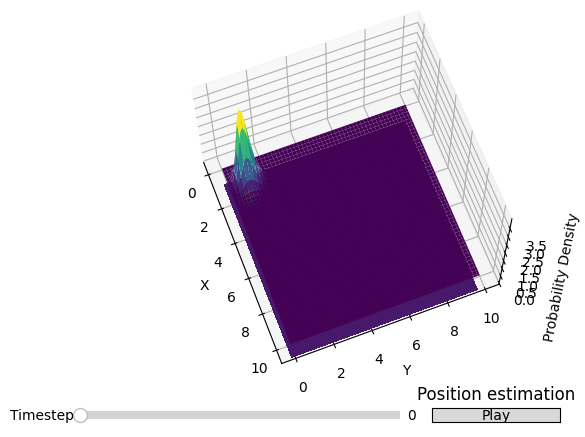

In [10]:
import modules.Robot_state_estimator as Robot_state_estimator
import importlib
importlib.reload(Robot_state_estimator)
Robot_state_estimator.test()

### **Thymio Interface (Control)**
This modules is everything related to the thymio

It allows the other modules to get sensors data and to apply position target to the robot

We used a P controller to control the thymio. The signal to control the motor is normalised between [-1,1] with minus one being the reverse max speed and one the max speed.
We determine the K coefficients for turning and moving forward by hand.

If the command is to move to a certain given point, this module computes the angle between the thymio and the target angle and make the thymio turning in consequence. Once inside a tolerance angle, thymio start moving toward the goal.


#### **Principle**

#### **Functions**

async def move_toward_pos(self, goal_pos,orientation,pos):

    if math.dist(goal_pos,pos) < self.tolerance_pos:
        self.apply_motor_control((0,0),0)
        return True
    vector_direction = (goal_pos[0]-pos[0],goal_pos[1]-pos[1])
    orientation_traj = Tools.angle_between((1,0),vector_direction)
    print("goal_angle: ",orientation_traj*180/math.pi,"vector: ",vector_direction)
    diff =( orientation_traj - orientation)

    if (diff > math.pi):
        diff -= 2*math.pi
    if (diff < -math.pi):
        diff += 2*math.pi
    # diff = min(max(diff,-360),360)
    print("diff: ",diff,"(",diff*180/math.pi,")","dist",math.dist([vector_direction[0]],[vector_direction[1]]))
    if  abs(diff) < self.tolerance_angle: # move forward
        v = self.min_max_slide(math.dist([vector_direction[0]],[vector_direction[1]]),True)
        self.apply_motor_control((v,v),True)
    else : # move counter clockwise for > 0 clockwise for < 0
        v = self.min_max_slide(diff[0],False)
        self.apply_motor_control((-v,v), False)
    return False
def min_max_slide(self,value,forward):
    if forward:
        coef = max(min(self.k_dist*value,1),-1)
    else:
        coef = max(min(self.k_angle*value,1),-1)
    return coef
def apply_motor_control(self,motor_control,forward):
    print("control: ",motor_control)
    control = {
        "motor.left.target": [int(motor_control[0]* (self.speed_forward if forward == True else self.speed_turning))],
        "motor.right.target": [int(motor_control[1]* (self.speed_forward if forward == True else self.speed_turning))],
    }
    self.node.send_set_variables(control)

In [3]:
import modules.Tymio_interface as Tymio_interface
import importlib
importlib.reload(Tymio_interface)
await Tymio_interface.test()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

### **Vision**

#### **Principle**

The camera is used as a sensing tool for environment mapping and robot localization. The mapping process is conducted at the beginning of the whole system, returning the map matrix, which consists of zeros standing for available grids and ones for occupied grids, the position of the target (x_t, y_t), and the robot information, which includes robot position (x, y) and the rotation angle theta. The robot localization process runs continuously among the navigation, giving position and rotation of the robot with the help of kalman filter.

The camera used is AUKEY Stream Series 1080p Webcam. Robot and target detection are completed with Aruco Markers. OpenCV-python is used as dependency.



#### **ArUco Markers**

When designing the vision part, several methods were considered and experimented. For example, we tried color detection with different colors used for different objects, which is not robust enough in changing lighting conditions, and feature detection for circles and polygons, which is easily affected by irrelavant circles on the robot. After the trials, the map are set completely with black and white, and ArUco markers are used for easier localization. 

ArUco library is a popular library developed by Rafael Muñoz and Sergio Garrido [1] for detection of square fiducial markers. The ArUco method is robust in different lightening conditions and different marker sizes. In this project, we used the OpenCV aruco module based on the ArUco library.

The ArUco module works in 4 steps: contour extraction, marker code extraction, marker identification and error correction. After the contours in the image are extracted, contours which are not approximately 4-vortex polygons are discarded, since the markers are enclosed in rectangular contours. Then, inner region of the contours is coded into binarized regular grid, depending on the value of the majority of pixels within the grid. The marker identification is made by searching through dictionary set, which is sorted as a balanced binary tree to speed up the process. If no matches are found in the dictionary, the marker candidate will be discarded or recognized as the one with closest Haming distance in the dictionary. The ArUco module returns the id, corner position of each marker for further use.

#### **Pre-processing**

There are several issues with the original frames read in directly by the camera: chromatic abberation, noise, and unstandardization of frames caused by the camera position and shooting angle change. Thus, pre-processing is needed for the original frames before the detection on markers and further process. 

The map region is extracted from the whole image with the help of 4 markers set at the 4 corners of the map. Perspective projection is then removed with projective transform, thus ensure our method is robust with changes on camera position and shooting angle. Since the map is designed as completely white and black, the original image is turned to grayscale image. The noise of the grayscale image is filtered by Gaussian filter, in order to get high SNR image. Finally, the image is thresholed into binary, making the mapping process much easier.

The current pre-processing method might be improved by using different filters or thresholding methods. The Gaussian filter used in this project successfully solved this specific assignment, but we also noticed that the Gaussian filter blurs the edges. The ArUco methods highly depends on edge detection to localiza the markers, so if the markers we use are much smaller than the current ones, issues caused by the blurring might occur. In this case, median filter can be used for better edge detection in ArUco library. Moreover, when the lightening codition is much worse, causing severe random shadows on the map, the simple binary thresholding method might get worse performance. In that case, Gaussian adaptive thresholding can be a way to improve. 


#### **Mapping and Localization**

After pre-processing, the image is cropped into grids. In each grid, if there is a black representing the "wall", the average value of the cropped gird would be smaller than the unoccupied grids which is almost totally white. We set proper threshold value to seperate available grids and occupied grids. ArUco markers are also attached onto the robot and used to mark the goal. Localization of the robot and the goal is done by the ArUco library. Since the goal and the robot are also in the map region, we correct the grids occupied by the robot and the goal into available grids.

The robot position and rotation angle gained by the vision module cannot be directly used in control and navigation modules. The sensoring from vision module and the estimation of position and angle gained from motor speed will both be used in the robot state estimation module, giving a more precise estimation about the real-time state of the robot. The vision module runs at around 5 fps speed as required by the robot state estimation module. More details were introduced in Robot State Estimation module above.

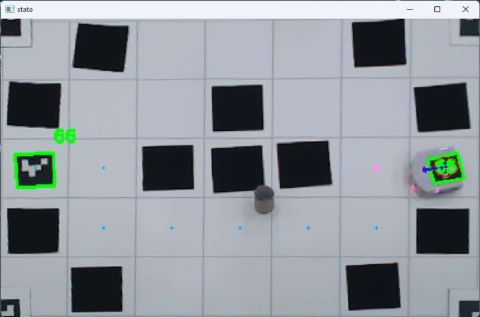

Figure 3: As shown in the figure above, in the vision module, map region is cut out from the initial frame read in from the camera, and perspective projection is removed by the perspective transform with the help of ArUco markers on four corners. The robot and the goal is localized with ArUco markers attached.

#### **Key Codes**

Pre-processing for noise and simplifying the further process:

        # convert in gray scale
        gray = cv2.cvtColor(image_flat, cv2.COLOR_BGR2GRAY)
        
        # blur the image
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        
        # threshold the image
        mask = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]
        
Pre-processing for extracting map region and removing perspective projection:

        # Compute the perspective transform M
        M = cv2.getPerspectiveTransform(input_pts,output_pts)
        out = cv2.warpPerspective(image,M,(maxWidth, maxHeight),flags=cv2.INTER_LINEAR)
        
Main loop for building map matrix:

        for i in range(self.nb_blocks_y):
            for j in range(self.nb_blocks_x):
                x = j*block_size_x
                y = i*block_size_y
                
                cropped_image = mask[y:y+block_size_y,x:x+block_size_x]
                cv2.rectangle(image_flat_output, (x,y), (x+block_size_x,y+block_size_y), (0,0,255), 2)
                
                average= np.mean(cropped_image)
                if (average <= self.black_threshold):
                    grid[i][j] = 1   # standing for occuiped grids with walls 
                else:
                    grid[i][j] = 0   # standing for available grids
                    
Detecting ArUco markers and getting rotation angle of the markers:

        arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT[self.aruco_type])
        arucoParams = cv2.aruco.DetectorParameters_create()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)
      
        self.display_markers(corners, ids, rejected, image)
        
        centers = {}
        orientations = {}
        if len(corners) > 0:
            ids = ids.flatten()
            for (markerCorner, markerID) in zip(corners, ids):
                corners = markerCorner.reshape((4, 2))
                (topLeft, topRight, bottomRight, bottomLeft) = corners
                topRight = (int(topRight[0]), int(topRight[1]))
                bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
                bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
                topLeft = (int(topLeft[0]), int(topLeft[1]))
                cX = int((topLeft[0] + bottomRight[0]) / 2.0)
                cY = int((topLeft[1] + bottomRight[1]) / 2.0)
                centers[markerID] = (cX, cY)
                
                orientations[markerID] = (topLeft[0]-bottomLeft[0],(topLeft[1]-bottomLeft[1]))

#### **Reference**

[1] S. Garrido-Jurado, R. Muñoz-Salinas, F. J. Madrid-Cuevas, and M. J. Marín-Jiménez. 2014. "Automatic generation and detection of highly reliable fiducial markers under occlusion". Pattern Recogn. 47, 6 (June 2014), 2280-2292. DOI=10.1016/j.patcog.2014.01.005

### Here are code to run the vision (camera required)

perspective {33: (483, 580), 44: (1036, 578), 66: (533, 327), 11: (363, 196), 22: (1065, 147), 55: (919, 419)}
[[0. 1. 0. 0. 0. 1. 0.]
 [1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 0.]] [2 5] [1 1]


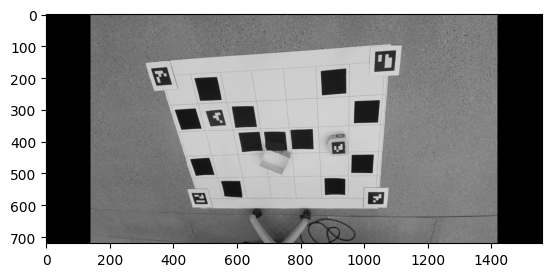

In [27]:
import cv2
import modules.Vision as Vision
import importlib
importlib.reload(Vision)
import numpy as np
import matplotlib.pyplot as plt

vision = Vision.Vision(0,7,5,100,50,corners_grid_ids=[11,22,33,44],robot_id=55,goal_id=66,black_threshold=189,aruco_type = "DICT_4X4_250")
# Time to do color calibration
vision.wait_for_color_calibration()


frame = cv2.imread('test_background.jpg')
plt.imshow(frame)
grid,start,goal = vision.process_image(frame)
print(grid,start,goal)
# pos, ori = vision.get_position_orientation(frame)
# print(pos,ori)

cv2.destroyAllWindows()

### **Global Navigation**

#### **Principle**

Global Navigation requires some information to be able to run properly, the lay-out of the map (corners, walls and roads), the start position and the goal. Once these are defined it will calculate the shortest path that is free, to reach its goal.

To achieve this it uses a few important elements:
- a coordinate assignment section
- a heuristic distance estimation
- an A* search algorithm
- a path reconstructing function

*(Labday 5 was used as a reference for the Global Navigation module)*

#### **Functions**

*Coordinate assignment*

        x, y = np.mgrid[0:self.max_valx:1, 0:self.max_valy:1]
        self.pos = np.empty(x.shape + (2,))
        self.pos[:, :, 0] = x;
        self.pos[:, :, 1] = y
        self.pos = np.reshape(self.pos, (x.shape[0] * x.shape[1], 2))
        self.coords = list([(int(x[0]), int(x[1])) for x in self.pos])

The coordinate assignment creates a grid depending on the given values for the lengths in x and y. With this it assigns a coordinate as a tuple for every square in the grid, with rows being the first element and columns the second.

*Heuristic*

        self.h = np.linalg.norm(self.pos - self.goal, axis=-1)
        self.h = dict(zip(self.coords, self.h))

The heuristic uses the coordinate system created above and calculates an approximate distance between the position at that moment and the goal, while ignoring all the obstacles. The obtained norm will always be smaller or equal to the cost of the optimal path defined by the A* algorithm.

*A\* algorithm*

The A* algorithm is a classic path planning algorithm that calculates the cheapest path between the start node and the goal node. It does this using the heuristic distance determined before to optimize the search, which makes it better than Dijkstra's algorithm.

*Path reconstruction*

    def reconstruct_path(self, cameFrom, current):

        total_path = [current]
        while current in cameFrom.keys():
            # Add where the current node came from to the start of the list
            total_path.insert(0, cameFrom[current])
            current = cameFrom[current]

        print(total_path)

        return total_path

The reconstruct_path function makes a list containing the nodes visited for the optimal path by tracing back each step and adding them to the list. It then returns this list with all the nodes in the order from start to goal.

### **Local Navigation**

#### **Assumptions**

In our environment we place one or more obstacles in the path that the robot will take. The goal of this module is to trigger Local Navigation when an obstacle is detected. 
The proximity sensors' captured values will trigger Local Navigation when these are above a desired threshold value of distance.
The Local Navigation is set by a series of assumptions:
1. The obstacles are **not completly blocking the path** of the robot. This is due to the fact that we decided to run Global Navigation only once at the beginning of the program. This assumption allows Local Navigation to be fully centered around the objective of avoiding a given obstacle while not being limited by Global Navigation assumptions.
2. The obstacle will be **light reflective**. This is due to the fact that the proximity sensors are using infrared light. It has a transmitter and a receiver with the light "bouncing" on the obstacle back. This assumptions imposes the obstacle to not be glass for example as the light would mostly be diffracted instead of reflected.
3. The obstacle will have a **simple convex geometrical** section: Circles, Triangles, Squares... This assumption allows the robot to always be able to get around the object by following its external faces. Concave objects might create impossible object circling as the robot, having a given shape, might not fit inside the concave sections.


#### **Principle**

The robot will follow its course along the path given by Global Navigation. At each iteration of the main *while* loop, the Manager will call the proximity sensor function responsible to detect if there is an obstacle that has to be avoided. 
```
def is_obstacle(prox_sensor)->bool:
    prox_sensor = np.array(prox_sensor)
    is_obstacle_per_sensor = np.greater(prox_sensor,threshold_int)
    avoidance_occurring = np.any(is_obstacle_per_sensor)
    which_obstable = np.where(is_obstacle_per_sensor)[0]

    obstable_int = prox_sensor
    which_obstable = which_obstable.tolist()
    full_prox_cm = int_to_cm(prox_sensor)
    return avoidance_occurring
```
If not any obstacle is detected the *while* continues. Otherwise, the Manager will get in a new *while* loop receiving the control of the motors given by Local Navigation to avoid the obstacle.

```
def compute_avoidance(prox_sensor_int,current_position,next_step_position):
    if not compute_avoidance_started:
        start_avoidance(current_position,next_step_position)

    elif has_avoided(current_position):
        stop_avoidance()

    return not avoidance_occurring,get_avoidance_vel(prox_sensor_int)
```

In this new *while* loop, the Manager will call a function of Local Navigation to check if the obstacle avoidance algorithm has come to an end. The algorithm wil be explained later on.

#### **Avoidance algorithm**

The algorithm starts by locating where the obstacle is placed, refered to the direction of the robot. Is it on its left or on its right?
Thanks to the proximity sensors values we find that the obstacle is closer to one side of the robot's proximity sensors. This is done by checking the sign of:
$$ side = sign(\sum{sign(\theta _{sensor,i})d_{measured}})$$

```
    where_obstacle = np.sign(sensor_angle_from_direction[which_obstable]) @ np.transpose(obstable_int[which_obstable])
    if where_obstacle >= 0:
        direction_of_avoidance = RIGHT
    else:
        direction_of_avoidance = LEFT
```

From there we know that if the obstacle is on the left, the robot will have to avoid it by the right and vice-versa.

The robot will then circle around the obstacle in the above set direction until a stop condition is verified. The control of the motor is explained later on.

The stop condition is when the robot crosses the line between the point where the avoidance algorithm started and the point of the next node (according to Global Navigation) to travel to. (<cite>[Lesson 4/5 Navigation][1]</cite>).

<div style="text-align: center;"><img src="./images/Avoidance.jpg" alt="Stop Avoidance" width="400"/></div>

```
def _is_point_good_side(self,direction_of_avoidance, current_vec, start_to_goal_vec):
    cross_p = np.cross(current_vec,start_to_goal_vec)
    if direction_of_avoidance == RIGHT:
        cross_p = -cross_p

    return (cross_p >= 0)
```

[1]: https://moodle.epfl.ch/pluginfile.php/2715095/mod_resource/content/12/Slides%2004_05%20-%20Navigation-5.pdf

#### **Motor control**

The motor control is necessary to be able to maintain a desired distance from the obstacle. The Thymio robot having only diagonally positionned proximity sensors and no sideways sensors makes this task a bit tricky.

This is why the robot will follow the obstacle profile whith its most tilted proximity sensor. If the profile has a corner the sensor will lose track of it. When that happens the robot will do a maneuver to pivot around a *possible corner* until a proximity sensor kicks in to follow the profile again.

#### **Proximity sensor Calibration**

The proximity sensors of the robot return intensity values. These values are non-linear with the distance and highly depend on the light in the environment where the robot will actuate.
Therefore, a look-up table was the decided choice to be able to compare the values from the sensors to real world distances.

To create this look-up table we dispose the robot right in front of a wall and make it go backwards while keeping track of the distance from the wall and getting the intensity values of the front proximity sensor.

*Code in file: prox_calibrate.py*

## *Conclusion*

The goal of the project has been attained. All the different submodules were implemented successfully and the code runs well.
Some difficulties did occur during the project. <br>

For the position estimator, tuning the parameters to find good values was the biggest challenge. It was solved by measuring and calculating the different values for movement and rotation. Let the robot go forward for 50 seconds to see how far it reached and let the robot turn on himself for 50 seconds to see how many angles it did. <br>

For the vision, it's main challenge appeared with the detection of map elements. The first version of the module used colors and shapes to read the outlines, objective and start. However due to the instability of this method it was later on switched to ArUco markers for its robustness and accuracy.

# Here is the manager code (runnable)

In [1]:
import asyncio
import time
import modules.Tools as Tools
import modules.Global_navigation as Global_navigation
import modules.Vision as Vision
import modules.Tymio_interface as Tymio_interface
import modules.Robot_state_estimator as Robot_state_estimator
import modules.Local_navigation as Local_navigation

import importlib
importlib.reload(Tools)
importlib.reload(Vision)
importlib.reload(Global_navigation)
importlib.reload(Tymio_interface)
importlib.reload(Robot_state_estimator)
importlib.reload(Local_navigation)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
# Config file return something like this 
# {'Manager': {'grid_width': 10, 'grid_height': 10, 'block_size': 20}, 'Global_navigation': None, 'Local_navigation': None, 'Robot_state_estimator': None, 'Tymio_interface': None, 'Vision': None}
class Manager:
    # init all the modules
    def __init__(self, config_file):
        config = Tools.read_config_file(config_file)
        vision_config = config["Vision"]
        self.vision = Vision.Vision(
            vision_config["camera_id"],
            config["Map"]["nb_blocs_x"],
            config["Map"]["nb_blocs_y"],
            config["Map"]["nb_blocs_x"]*config["Map"]["bloc_size"],
            config["Map"]["nb_blocs_y"]*config["Map"]["bloc_size"],
            vision_config["corners_grid_ids"],
            vision_config["robot_id"],
            vision_config["goal_id"],
            vision_config["black_threshold"],
            vision_config["aruco_type"])
        self.robot_state_config = config["Robot_state_estimator"]
        self.robot_state_estimator = Robot_state_estimator.Robot_state_estimator(
            self.robot_state_config["Ks"],
            self.robot_state_config["Q"],
            self.robot_state_config["R"],
            self.robot_state_config["mean_init"],
            self.robot_state_config["cov_init"],
        )
        tymio_interface_config = config["Tymio_interface"]
        self.tymio_interface = Tymio_interface.Tymio_interface(
            tymio_interface_config["tolerance_pos"],
            tymio_interface_config["tolerance_angle"]*np.pi/180,
            tymio_interface_config["k_dist"],
            tymio_interface_config["k_angle"],
            tymio_interface_config["speed_turning"],
            tymio_interface_config["speed_forward"],
            tymio_interface_config["tymio_speed_to_mms"],
        )
        self.local = Local_navigation.Local_navigation(config["Local"])
        self.config = config
        print(config)


    async def connect(self):
        await self.tymio_interface.connect()
    def calibrate_camera(self):
        self.vision.calibrate_camera()

    # Estimation of the robot position and variance
    def calibrate_robot(self):
        pos_var, angle_var = self.vision.calibrate_position_angle(500)
        print("pos_var",pos_var,"angle_var",angle_var)
        R = self.robot_state_config["R"]
        R[0][0] = pos_var[0]
        R[1][1] = pos_var[1]
        R[2][2] = angle_var
        print("R",R)
        self.robot_state_estimator.R = R

    # Get the path from the global navigation module
    def path_planning(self,occupancy_grid,start,goal):
      
        print("start",start)
        print("goal",goal)
        print("occupancy_grid",occupancy_grid)
        self.global_naviation = Global_navigation.GlobalNavigation(
            tuple(start), tuple(goal), occupancy_grid.astype(int), self.config["Map"]["nb_blocs_y"], self.config["Map"]["nb_blocs_x"], self.config["Global_navigation"]["mouvement_type"],  self.config["Map"]["bloc_size"])
        # Run the A* algorithm
        path, visitedNodes = self.global_naviation.A_Star()
        cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

        fig_astar, ax_astar = Tools.create_empty_plot(self.config["Map"]["nb_blocs_y"], self.config["Map"]["nb_blocs_x"])
        ax_astar.imshow(occupancy_grid, cmap=cmap)

        # Plot the best path found and the list of visited nodes
        ax_astar.scatter([e[1] for e in visitedNodes], [e[0] for e in visitedNodes], marker="o", color='orange');
        
        ax_astar.plot([e[1] for e in path], [e[0] for e in path], marker="o", color='blue');
        ax_astar.scatter(start[1], start[0], marker="o", color='green', s=200);
        ax_astar.scatter(goal[1], goal[0], marker="o", color='purple', s=200);
        path = list((np.asarray(path) + 0.5) * self.config["Map"]["bloc_size"])
        path = [(e[1],e[0]) for e in path]
        return path

    
    async def run(self):
        # Get the occupancy grid
        path = None
        while 1:
            try:
                grid, start, goal = self.vision.compute_vision()
                path = self.path_planning(grid, start, goal)

                pos, angle, _ = self.vision.get_position_orientation()
                self.robot_state_estimator.mean_state = np.array([[pos[0]], [pos[1]], [angle], [0], [0]])
                break
            except Exception as e:
                print("Error in vision",e)
                continue
        
        print(path)
        start_start = time.time()

        state_avoiding = False
        is_on_traj = True
        # Main loop
        while 1:

            # Try to get the position and orientation of the robot
            camera_meas = True
            try:
                pos, angle, image_flat = self.vision.get_position_orientation()
            except Exception as e:
                print("Error in vision",e)
                camera_meas = False

            (prox,vr,vl) = await self.tymio_interface.get_sensors()
            prox = list(prox)[0:5]
            end_time = time.time()
            time_diff = end_time-start_start
            self.robot_state_estimator.compute_robot_state(pos[0],pos[1],angle,vr,vl,camera_meas,time_diff)
            start_start = time.time()

            (pos,angle,cov, cov_angle) = self.robot_state_estimator.get_position_angle_mean_cov()
            local_goal = path[0]
            
            if not state_avoiding:
                # Check if there is an obstacle on the trajectory
                local_pos = pos
                next_local_goal = list(path[0])
                angle = angle[0]
                state_avoiding = self.local.is_obstacle(list(prox),local_pos.transpose(),np.asarray(list(next_local_goal)),angle) and is_on_traj
                if state_avoiding:
                    if len(path) != 1:
                        path.pop(0)
                        if len(path) == 0:
                            break
            else:
                if not self.local.avoidance_occurring:
                    state_avoiding = False


            if not state_avoiding:
                # Recompute the path if the robot is too far from the checkpoint
                if (Tools.distance(pos,local_goal) > 1.5*self.config["Map"]["bloc_size"]):
                    print("Recomputing path")
                    while 1:
                        try:
                            grid, start, goal = self.vision.compute_vision()
                            path = self.path_planning(grid, start, goal)
                            local_goal = path[0]
                            break
                        except Exception as e:
                            print("Error in recomputing path:",e)
                            continue
                print("------------------")
                print("cov",cov,"cov_angle",cov_angle)
                print("pos",pos,"angle",angle*180/np.pi,"local_goal",local_goal,"time",time_diff)
                print("camera",camera_meas,"motor speed",vr,vl)
                
                # Move the robot toward the checkpoint
                success,is_on_traj = await self.tymio_interface.move_toward_pos(local_goal,angle,pos)
                
                print("------------------", success)
                if success:
                    path.pop(0)
                    if len(path) == 0:
                        break
            else:
                local_pos = pos
                next_local_goal = list(path[0])

                avoided,vl,vr = self.local.compute_avoidance(list(prox),local_pos.transpose(),np.asarray(list(next_local_goal)))
                if avoided:
                    continue
                else:
                    self.tymio_interface.apply_motor_control((vl,vr),False)
                    await self.tymio_interface.client.sleep(0.4)
                   

            await self.tymio_interface.client.sleep(0.2)
            image_to_plot = image_flat.copy()
           
            self.vision.plot_state(image_to_plot,pos,angle,[np.array([i[:2] for i in cov[:2]])],cov_angle,local_goal,path)

            
            # Display the resulting frame     
            key = cv2.waitKey(1) #pauses before fetching next image
            if key == 27: #if ESC is pressed, exit loop
                await self.release()
                cv2.destroyAllWindows()
                break


    async def release(self):
        self.tymio_interface.apply_motor_control((0,0),False)
        self.vision.cam.release()
        cv2.destroyAllWindows()
        await self.tymio_interface.release()


async def main():
    manager = Manager("config.yaml")
    await manager.connect()
    # manager.calibrate_camera()
    manager.vision.wait_for_color_calibration()
    # manager.calibrate_robot()
    await manager.run()
    await manager.release()

await main()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it